# Import the modules

In [348]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Build the data we'll work on

In [349]:
df_price = pd.read_csv("../../../price_computed/average_prices.csv", sep=";")
header = df_price.columns # The header contains all the days for which we have data
print(f'Header of the dataframe \n{header}')
np_price = df_price.to_numpy()
print(f'Prices Numpy array (with products names) \n{np_price}')

Header of the dataframe 
Index(['Unnamed: 0', 'Produit', '2014-01-02', '2014-01-03', '2014-01-06',
       '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
       ...
       '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30',
       '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07'],
      dtype='object', length=1827)
Prices Numpy array (with products names) 
[[0 'ABRICOT' 2.5 ... 2.2 2.18 2.18]
 [1 'AIL' 3.69 ... 4.22 4.22 4.22]
 [2 'ANANAS' 1.77 ... 2.18 2.14 2.14]
 ...
 [65 'ÉCHALION' 1.05 ... 1.3 1.3 1.3]
 [66 'ÉCHALOTE' 1.25 ... 3.05 3.05 3.05]
 [67 'ÉPINARD' 1.9 ... 1.8 1.8 1.8]]


Now we need to just keep the prices of our products

In [350]:
prices = np_price[:,2:]
print(f"Prices array with a shape of {prices.shape}\n{prices}")

Prices array with a shape of (68, 1825)
[[2.5 2.5 2.5 ... 2.2 2.18 2.18]
 [3.69 3.69 3.69 ... 4.22 4.22 4.22]
 [1.77 1.77 1.77 ... 2.18 2.14 2.14]
 ...
 [1.05 1.05 1.05 ... 1.3 1.3 1.3]
 [1.25 1.25 1.25 ... 3.05 3.05 3.05]
 [1.9 1.9 1.9 ... 1.8 1.8 1.8]]


That big array will be useful at the end of the simulation. Now we need two samples : the training one and the test one.
First we have to exract the labels of our data : the CPI. Note that it's given to us only month by month from 2014 to 2021.

In [410]:
df_ipc = pd.read_csv("../ipc2014-21.csv", sep = ";").to_numpy() #IPC

IPC = df_ipc[:,1:].astype(np.float64) #Conversion from string to float

IPC = IPC[::-1] #Reading IPCs backward to get them chronogically

IPC_train = IPC[:len(prices)] #IPCs used to learn
IPC_test = IPC[len(prices):]  #IPCs used to test the model
print(f'Train label sample length : {len(IPC_train)}')
print(f'Test label sample length : {len(IPC_test)}')

Train label sample length : 68
Test label sample length : 20


Then we need to extract the prices month by month. We proceed by average the daily prices over months.

In [352]:
months_viewed = dict() # Dict of months viewed with the number of iterations
prices_dict = dict() # Dict of average prices for each month

for item in header[2:]:
    date = '-'.join(item.split('-')[:2])
    if date in months_viewed.keys():
        months_viewed[date] += 1
        prices_dict[date] += df_price[item].to_numpy()
    else:
        months_viewed[date] = 1
        prices_dict[date] = df_price[item].to_numpy()
for obj in months_viewed.items():
    prices_dict[obj[0]] /= obj[1]

In [353]:
i = 0
prices_monthly = []
L = len(IPC_train)
for month_prices in prices_dict.values():
    prices_monthly.append(month_prices)

Then we can preprocess our data, with a standard scaling.

In [354]:
scaler = StandardScaler()
scaler.fit(prices_monthly)
scaler.transform(prices_monthly)
prices_train = np.array(prices_monthly[:len(IPC_train)])
prices_test = np.array(prices_monthly[len(IPC_train):])

In [361]:
def Prediction(model, parameter, variation_list):
    Model = model
    n_list = variation_list
    tuned_parameters = {parameter: n_list}
    nb_folds = 5
    grid = GridSearchCV(Model, tuned_parameters, cv=nb_folds, refit=True, verbose=1, scoring='r2')
    grid.fit(prices_train, IPC_train.ravel())
    print(f'Best model found : {grid.best_estimator_}')
    Model = grid.best_estimator_
    Predict_test = Model.predict(prices_test)
    Predict = Model.predict(prices_monthly)
    return Predict

In [362]:
def Graph(prediction, real_values, model):
    plt.plot(Predict, label='Prediction')
    plt.plot(IPC, label='Real IPC')
    plt.xticks(list(range(89))[::10], [i for i in months_viewed.keys()][::10], rotation = 45)
    plt.grid()
    plt.legend()
    plt.title(f'Prediction attempt with {model}')
    plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best model found : DecisionTreeRegressor(max_depth=5)


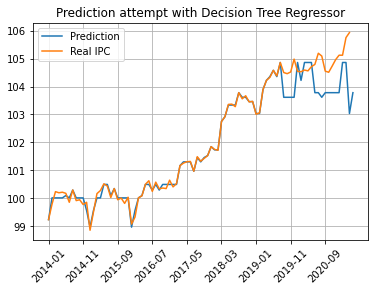

In [363]:
Predict = Prediction(DecisionTreeRegressor(), 'max_depth', np.arange(5, 30, 1))
Graph(Predict, IPC, 'Decision Tree Regressor')

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best model found : KNeighborsRegressor(n_neighbors=4)


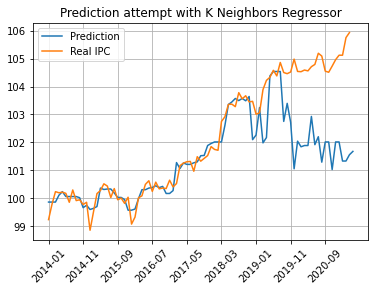

In [364]:
Predict = Prediction(KNeighborsRegressor(), 'n_neighbors', np.arange(1, 30, 1))
Graph(Predict, IPC, 'K Neighbors Regressor')

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best model found : KNeighborsRegressor(n_neighbors=4)


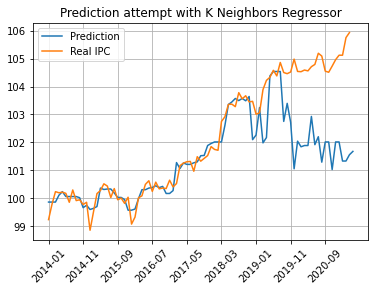

In [365]:
Predict = Prediction(KNeighborsRegressor(), 'n_neighbors', np.arange(1, 30, 1))
Graph(Predict, IPC, 'K Neighbors Regressor')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best model found : GradientBoostingRegressor()


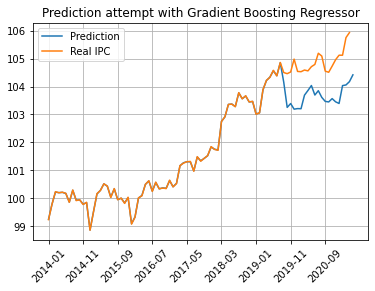

In [366]:
Predict = Prediction(GradientBoostingRegressor(), 'n_estimators', np.arange(50, 500, 50))
Graph(Predict, IPC, 'Gradient Boosting Regressor')

As we can see, even with the cross-validation process, we cannot make good predictions on CPI. However we just want to predict the next month CPI, so let's try to predict month by month, adding a re-learning at each month.

In [372]:
print(IPC_test[0])

[104.5]


In [409]:
def Prediction_monthly_with_grid(model, parameters, variation_lists, test_labels, train_labels, test_features, train_features):
    Predict = train_labels
    rank = 1
    L = test_labels.shape[0]
    while rank < L:
        Model = model
        for parameter, variation_list in zip(parameters, variation_lists):
            n_list = variation_list
            tuned_parameters = {parameter: n_list}
            nb_folds = 5
            grid = GridSearchCV(Model, tuned_parameters, cv=nb_folds, refit=True, scoring='r2')
            grid.fit(prices_train, IPC_train.ravel())
            print(f'Best model found : {grid.best_estimator_}')
            Model = grid.best_estimator_
        Predict_one = Model.predict(test_features[0].reshape(1, -1))
        train_features = np.append(train_features, test_features[0])
        test_features = test_features[1:]
        Predict = np.append(Predict, Predict_one)
        train_labels = np.append(train_labels, test_labels[0])
        test_labels = test_labels[1:]
        rank += 1
    return Predict

(87,)


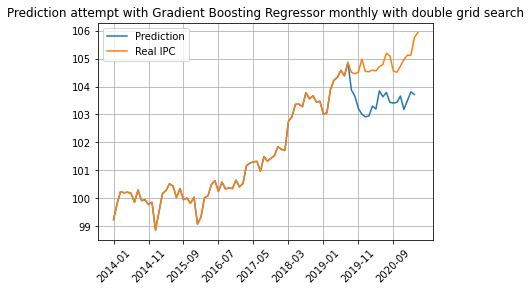

In [407]:
parameters = ['n_estimators', 'alpha']
values = [np.arange(50, 500, 50), np.arange(0.1, 1.0, 0.1)]
Predict = Prediction_monthly_with_grid(GradientBoostingRegressor(loss='quantile'), parameters, values, IPC_test, IPC_train, prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Gradient Boosting Regressor monthly with double grid search')

Best model found : GradientBoostingRegressor(n_estimators=200)
Best model found : GradientBoostingRegressor(alpha=0.30000000000000004, n_estimators=200)
Best model found : GradientBoostingRegressor(n_estimators=250)
Best model found : GradientBoostingRegressor(alpha=0.30000000000000004, n_estimators=250)
Best model found : GradientBoostingRegressor(n_estimators=350)
Best model found : GradientBoostingRegressor(alpha=0.8, n_estimators=350)
Best model found : GradientBoostingRegressor()
Best model found : GradientBoostingRegressor(alpha=0.2)
Best model found : GradientBoostingRegressor(n_estimators=250)
Best model found : GradientBoostingRegressor(alpha=0.7000000000000001, n_estimators=250)
Best model found : GradientBoostingRegressor(n_estimators=350)
Best model found : GradientBoostingRegressor(alpha=0.7000000000000001, n_estimators=350)
Best model found : GradientBoostingRegressor(n_estimators=200)
Best model found : GradientBoostingRegressor(alpha=0.2, n_estimators=200)
Best model fo

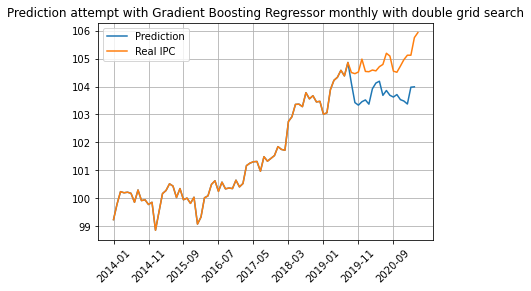

In [408]:
parameters = ['n_estimators', 'alpha']
values = [np.arange(50, 500, 50), np.arange(0.1, 1.0, 0.1)]
Predict = Prediction_monthly_with_grid(GradientBoostingRegressor(loss='ls'), parameters, values, IPC_test, IPC_train, prices_test, prices_train)
print(Predict.shape)
Graph(Predict, IPC, 'Gradient Boosting Regressor monthly with double grid search')

Then we need to extract the prices month by month. We proceed by average the daily prices over months.